# Dataset stats

Here, we examine a simulated dataset of ca. 181000 circuits and analyse its basic characteristics.

## Background

A large set of randomly generated RNA circuits was first created as a starting point and the binding energies of all RNAs were determined by the RNA simulator. This list of circuits was then filtered for circuits with a minimum number of 2 interacting species and at least 1 self interacting specie. From these, the first 1000 circuits were chosen as reference circuits. Each was then initialised with a set of mutated versions of itself, where each species was mutated at one of [1, 2, 3, 5, 10, 15] locations on its strand, with 10 variations in total. A reference circuit would thereby have a total of 3 (number of species) * 10 (variations) * 6 (number of mutations within a sequence) = 180 mutated subcircuits. 

Once all the circuits have been determined, their function must be determined. This involved first finding the steady state of the unbound and bound RNA species, then simulating the behavior of the circuit upon being perturbed by a step function. In this case, the step signal was a 2x increase in the species 'RNA_0', which happens instantaneously. In a lab experiment, there are many different ways of implementing this, each with a different delay, so the instantaneous increase presents the most extreme case.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


from functools import partial
import os
import sys
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from src.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from src.utils.misc.helper import vanilla_return
from src.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs, is_within_range
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.misc.type_handling import flatten_listlike, get_first_elements
from src.utils.misc.string_handling import prettify_keys_for_label
from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from src.utils.results.analytics.timeseries import generate_analytics
from tests_local.shared import CONFIG
from src.utils.common.setup_new import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

CONFIG = prepare_config(CONFIG)

In [ ]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_09_220322/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_09_220322/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_og)

## Distribution of interactions

The minimum free energy (kcal) of binding between each pair of RNA molecules in the circuit is calculated by the RNA simulator. This is then converted into an equilibrium constant through a parameterisation function that was estimated from experimental data (see notebook on calculating binding energies / interactions).

naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING


Text(0.5, 0.98, 'Interaction distributions of\nsource dataset')

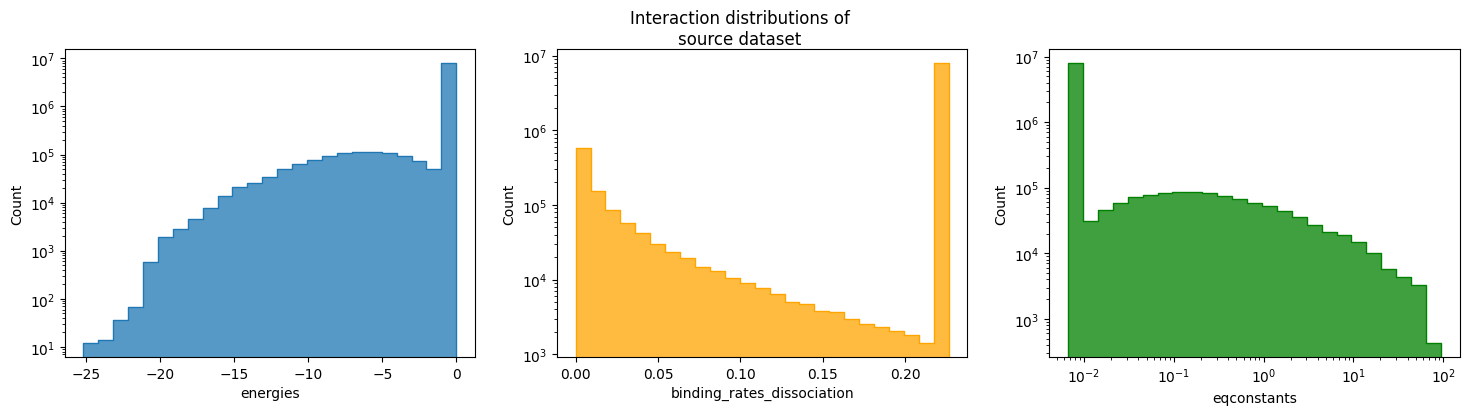

In [ ]:
dfm = data.melt(['name'], get_true_interaction_cols(data, 'energies'), value_name='energies', var_name='idx')
dfm1 = data.melt(['name'], get_true_interaction_cols(data, 'binding_rates_dissociation'), value_name='binding_rates_dissociation', var_name='idx')
dfm['binding_rates_dissociation'] = dfm1['binding_rates_dissociation']
dfm1 = data.melt(['name'], get_true_interaction_cols(data, 'eqconstants'), value_name='eqconstants', var_name='idx')
dfm['eqconstants'] = dfm1['eqconstants']
del dfm1

plt.figure(figsize=(18,4))
ax = plt.subplot(1,3,1)
sns.histplot(dfm, x='energies', log_scale=[False, True], element='step')
ax = plt.subplot(1,3,2)
sns.histplot(dfm, x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
ax = plt.subplot(1,3,3)
sns.histplot(dfm, x='eqconstants', log_scale=[True, True], element='step', color='g')

plt.suptitle('Interaction distributions of\nsource dataset')

The distribution of interactions in the dataset that includes all mutations still matches that of the original dataset, from which the 1000 source circuits were chosen.

In [ ]:
data = pd.read_csv(fn_mut)

In [ ]:
# data, datam, data_summ = enhance_data(data) 

data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:69: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(


In [ ]:

# datam = melt(data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log)

In [ ]:
# data_summ = summ(data, datam, bs_range_cols)

In [ ]:
data[data['sample_name'] == 'RNA_0'][(data['circuit_name'] == dfm[dfm['mutation_name'] == 'ref_circuit'].iloc[dfm[dfm['mutation_name'] == 'ref_circuit']['energies'].argmin()]['circuit_name']) &
     (data['mutation_name'] == dfm[dfm['mutation_name'] == 'ref_circuit'].iloc[dfm[dfm['mutation_name'] == 'ref_circuit']['energies'].argmin()]['mutation_name'])][get_true_interaction_cols(data, 'eqconstants')]



/tmp/ipykernel_2247430/4082569372.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['sample_name'] == 'RNA_0'][(data['circuit_name'] == dfm[dfm['mutation_name'] == 'ref_circuit'].iloc[dfm[dfm['mutation_name'] == 'ref_circuit']['energies'].argmin()]['circuit_name']) &


,eqconstants_0-0,eqconstants_0-1,eqconstants_0-2,eqconstants_1-0,eqconstants_1-1,eqconstants_1-2,eqconstants_2-0,eqconstants_2-1,eqconstants_2-2
183534,0.00667,1.491481,90.0591,1.491481,0.097195,0.00667,90.0591,0.00667,0.00667


In [ ]:
initial

[200, 200, 200]

In [ ]:
E = dfm[dfm['mutation_name'] == 'ref_circuit']['energies'].min()
E = np.array([0.0, -10.85, -23.83, -10.85, -5.36, 0.0, -23.83, 0.0, 0.0]).reshape(3, 3)

Keq = np.array([[6.6701183e-03, 1.4914810e+00, 9.0059100e+01, 1.4914810e+00, 9.7195335e-02, 6.6701183e-03, 9.0059100e+01, 6.6701183e-03, 6.6701183e-03]]).reshape(3, 3)

initial = np.array(sorted([r.quantity for r in circuits[0].qreactions.reactants if r.species in circuits[0].get_input_species()]))
Fs = np.exp(-0.8 * (E + 10))
Keq / Fs/initial

# (Fs / Keq )[2,0]

array([[9.94167121e-02, 3.77804809e-03, 7.05445486e-06],
       [3.77804809e-03, 1.98937448e-02, 9.94167121e-02],
       [7.05445486e-06, 9.94167121e-02, 9.94167121e-02]])

Text(0.5, 0.98, 'Interaction distributions of simulated dataset')

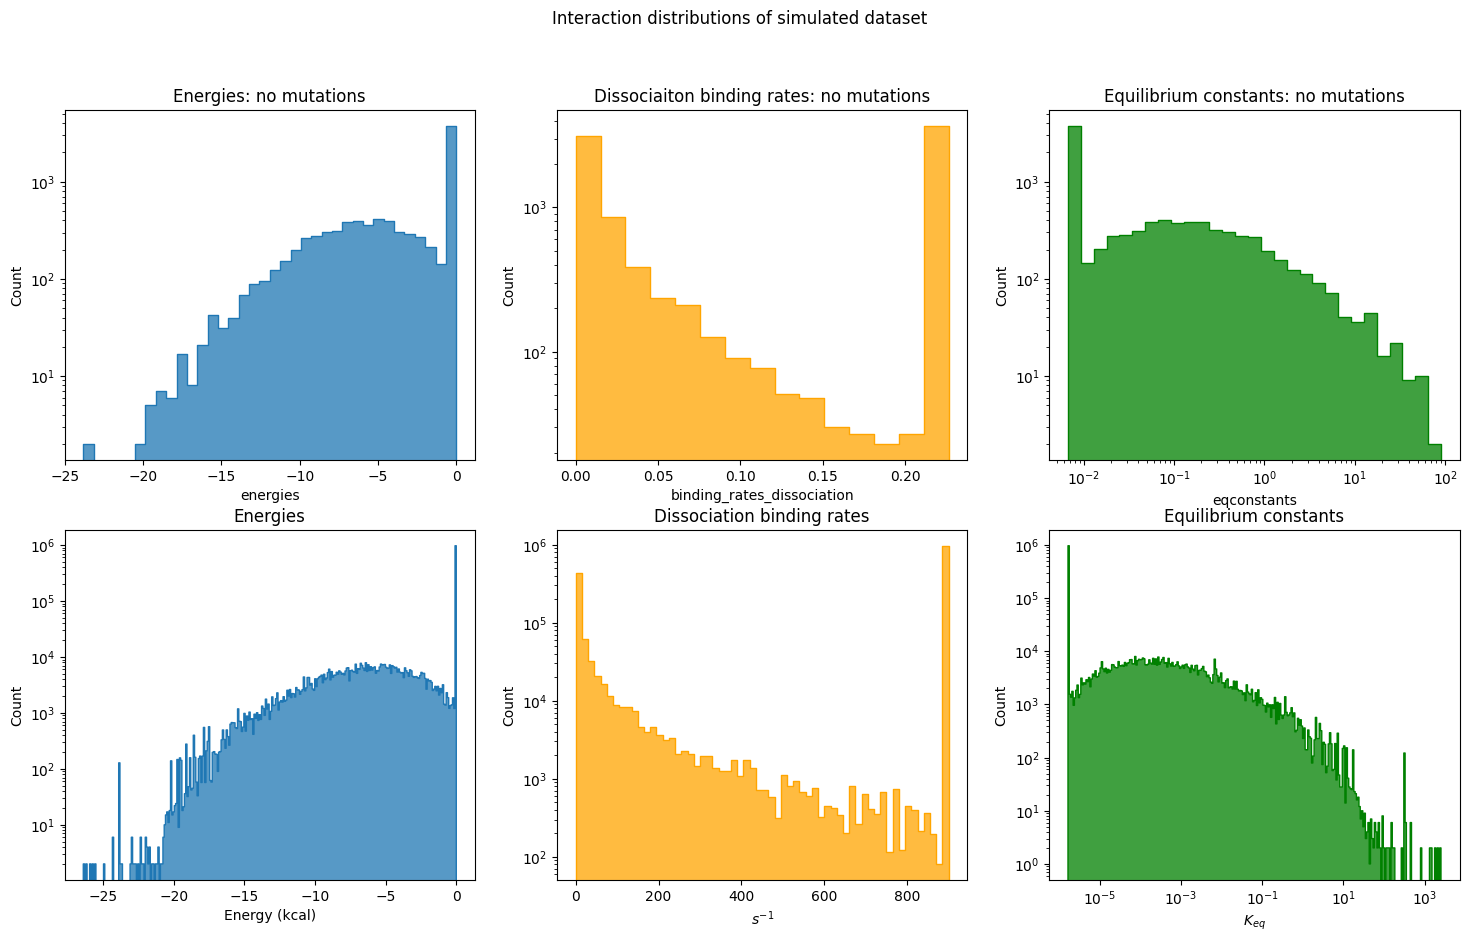

In [ ]:
dfm = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'energies'), value_name='energies', var_name='idx')
dfm1 = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'binding_rates_dissociation'), value_name='binding_rates_dissociation', var_name='idx')
dfm['binding_rates_dissociation'] = dfm1['binding_rates_dissociation']
dfm1 = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'eqconstants'), value_name='eqconstants', var_name='idx')
dfm['eqconstants'] = dfm1['eqconstants']
del dfm1

plt.figure(figsize=(18,10))
ax = plt.subplot(2,3,1)
sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='energies', log_scale=[False, True], element='step')
plt.title('Energies: no mutations')
plt.xlabel('Energy (kcal)')
ax = plt.subplot(2,3,2)
sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
plt.title('Dissociation binding rates: no mutations')
plt.xlabel('$s^{-1}$')
ax = plt.subplot(2,3,3)
plt.title('Equilibrium constants: no mutations')
sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='eqconstants', log_scale=[True, True], element='step', color='g')
plt.xlabel('$K_{eq}$')

ax = plt.subplot(2,3,4)
sns.histplot(dfm, x='energies', log_scale=[False, True], element='step')
plt.title('Energies')
plt.xlabel('Energy (kcal)')
ax = plt.subplot(2,3,5)
sns.histplot(dfm, x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
plt.title('Dissociation binding rates')
plt.xlabel('$s^{-1}$')
ax = plt.subplot(2,3,6)
sns.histplot(dfm, x='eqconstants', log_scale=[True, True], element='step', color='g')
plt.title('Equilibrium constants')
plt.xlabel('$K_{eq}$')

plt.suptitle('Interaction distributions of simulated dataset')

## Example trace of a circuit

Here is a demonstration of how a circuit's dynamics can be examined given some kind of input. In this case, the input is a step function of species `RNA_0`.

In [ ]:
data[(data['sample_name'] == 'RNA_0') & (data['mutation_name'] == 'ref_circuit')]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,name,interacting,self_interacting,num_interacting,...,sp_distance_logm,binding_sites_groups_0-0_logm,binding_sites_groups_0-1_logm,binding_sites_groups_0-2_logm,binding_sites_groups_1-0_logm,binding_sites_groups_1-1_logm,binding_sites_groups_1-2_logm,binding_sites_groups_2-0_logm,binding_sites_groups_2-1_logm,binding_sites_groups_2-2_logm
0,toy_circuit_combo0_100365,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100365,[[0 1]\n [0 2]],[[1 1]\n [2 2]],2,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
543,toy_circuit_combo0_100657,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100657,[[0 1]\n [0 2]],[[1 1]],2,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
1086,toy_circuit_combo0_100669,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100669,[[0 1]\n [0 2]],[[0 0]\n [1 1]],2,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
1629,toy_circuit_combo0_101802,ref_circuit,0,[],[],NaN,toy_circuit_combo0_101802,[[0 1]\n [1 2]],[[1 1]],2,...,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
2172,toy_circuit_combo0_10196,ref_circuit,0,[],[],NaN,toy_circuit_combo0_10196,[[0 2]\n [1 2]],[[0 0]],2,...,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540285,toy_circuit_combo0_99318,ref_circuit,0,[],[],NaN,toy_circuit_combo0_99318,[[0 2]\n [1 2]],[[1 1]],2,...,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN
540828,toy_circuit_combo0_993899,ref_circuit,0,[],[],NaN,toy_circuit_combo0_993899,[[0 1]\n [1 2]],[[1 1]],2,...,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
541371,toy_circuit_combo0_996650,ref_circuit,0,[],[],NaN,toy_circuit_combo0_996650,[[0 1]\n [1 2]],[[2 2]],2,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
541914,toy_circuit_combo0_998757,ref_circuit,0,[],[],NaN,toy_circuit_combo0_998757,[[0 1]\n [0 2]],[[0 0]\n [1 1]],2,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN


In [ ]:
def load_circuit(circ_row, config):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        matrix = [[0] * length for _ in range(length)]

        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1

        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')]),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')]),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')]),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')])}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

nm = 3
circuits = []
num_circuits = 3
for i in range(num_circuits):
    ref_c = data[(data['sample_name'] == 'RNA_0') & (data['mutation_name'] == 'ref_circuit')].iloc[i]
    mut_c = data[(data['sample_name'] == 'RNA_0') & (data['circuit_name'] == ref_c['circuit_name']) & (data['mutation_name'] != 'ref_circuit')].iloc[:nm]
    circuits.append(load_circuit(circ_row=ref_c, config=CONFIG))
    for mi in range(len(mut_c)):
        circuits.append(load_circuit(circ_row=mut_c.iloc[mi], config=CONFIG))
        

forward_rates = circuits[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])


t0 = 0 
t1 = 200
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits[0].signal.reactions_onehot) if circuits[0].use_prod_and_deg else np.zeros_like(circuits[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits[0].qreactions.reactions.inputs,
                            outputs=circuits[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, int(np.min([200, t1-t0]))))
                            )))


In [ ]:

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)


Done:  0:00:22.365412


In [ ]:
signal_species_idx = 6

b_steady_states = b_copynumbers[:, :, -1]
b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0]

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

Steady states:  200.0  iterations.  41  left to steady out.  0:00:21.080997
Steady states:  400.0  iterations.  20  left to steady out.  0:00:43.537482
Done:  0:01:04.751855


Text(0, 0.5, 'amount')

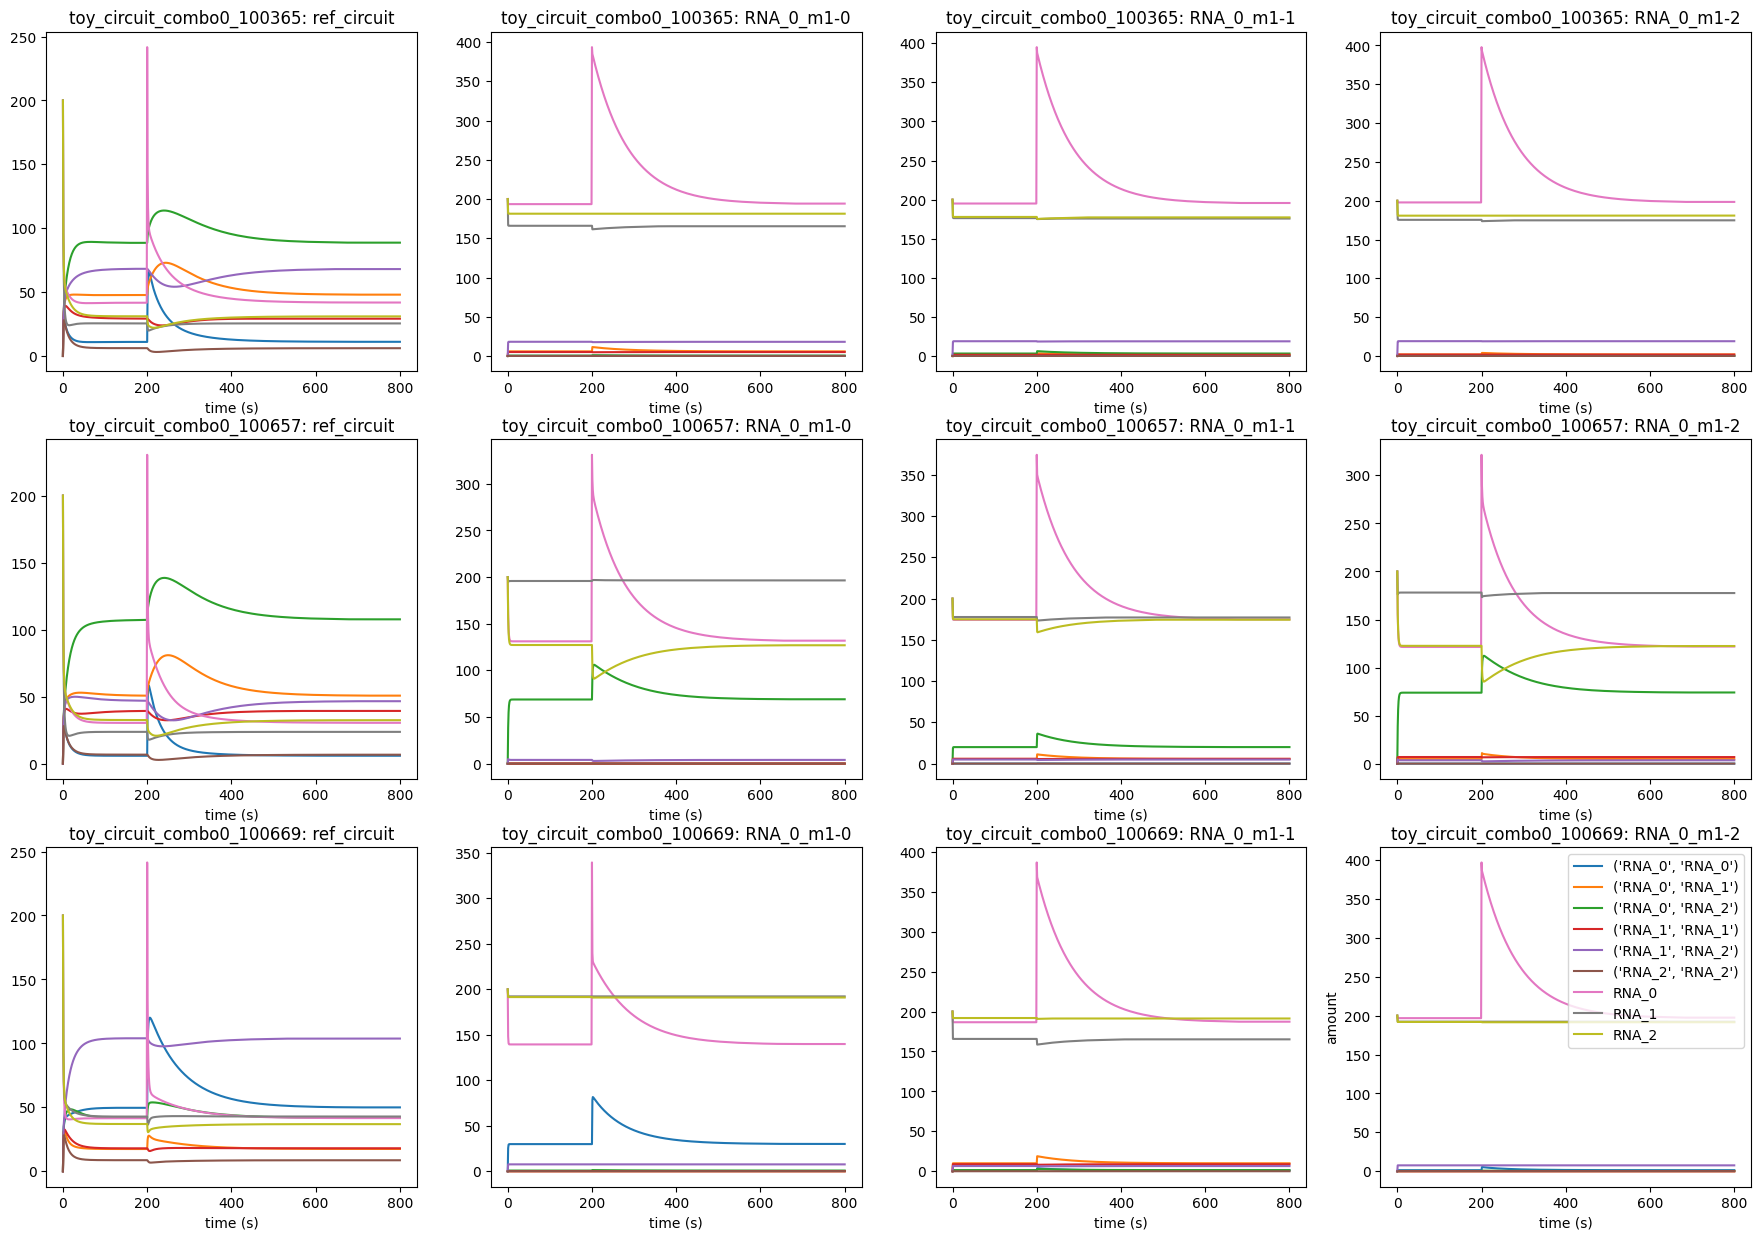

In [ ]:
plt.figure(figsize=(22, 15))
for i in range(len(circuits)):
    ax = plt.subplot(num_circuits,nm+1,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    plt.title(f'{circuits[i].name}: {circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
plt.ylabel('amount')


In the trace above, the steady state of all species is simulated first, followed by the simulation of the step response. Many species have an overshoot before they settle into their new steady states. This and other features can be analysed. 

### Analytics from trace

In [ ]:

def append_nest_dicts(l: list, i1: int, d: dict) -> list:
    for i in range(i1):
        b_analytics_k = {}
        for k, v in d.items():
            b_analytics_k[k] = v[i]
        l.append(b_analytics_k)
    return l
b_analytics_l = []
        
ref_idxs = [i for i, x in enumerate([c.subname for c in circuits]) if x == "ref_circuit"]
for ref_idx, ref_idx2 in zip(ref_idxs, ref_idxs[1:] + [len(circuits)]):
    ref_circuit = circuits[ref_idx]
    analytics_func = jax.vmap(partial(
        generate_analytics, time=tyy, labels=[
            s.name for s in ref_circuit.model.species],
        signal_onehot=ref_circuit.signal.onehot, signal_time=1))
    b_analytics = analytics_func(
        data=b_new_copynumbers[ref_idx:ref_idx2])
    
    b_analytics_l = append_nest_dicts(
        b_analytics_l, ref_idx2 - ref_idx, b_analytics)

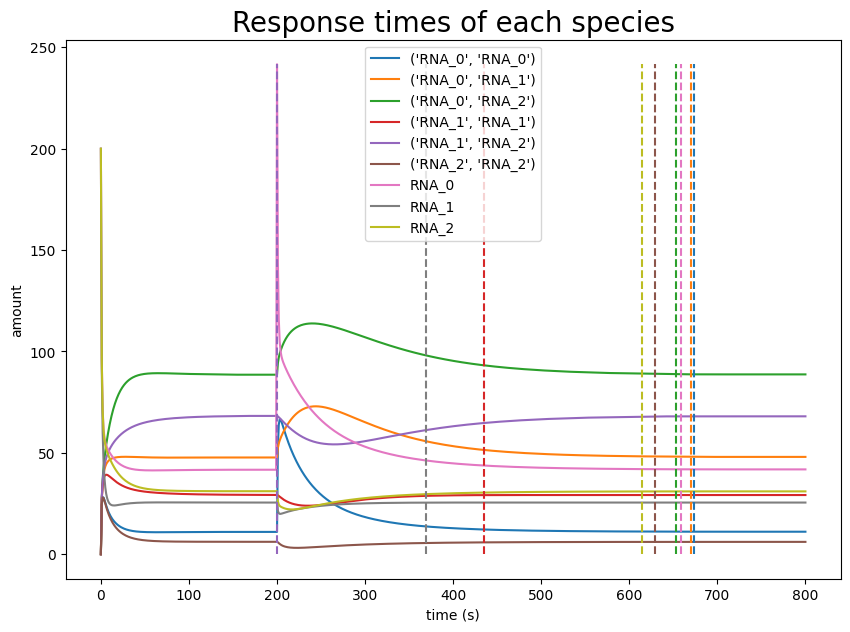

In [ ]:
i = 0
plt.figure(figsize=(10, 7))
plt.gca().set_prop_cycle(None)
plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]), )
plt.legend([s.name for s in circuits[0].model.species])
plt.xlabel('time (s)')
plt.ylabel('amount')
plt.title('Response times of each species', fontsize=20)

plt.gca().set_prop_cycle(None)
for s in range(len(circuits[0].model.species)):
    plt.plot(np.repeat(b_analytics_l[i]['response_time_wrt_species-6'], repeats=2, axis=1)[s] + t1, [0, np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]).max()], '--')

The response times above are shown in a dotted line, with each color corresponding to each species.

Text(0.5, 0.98, 'Sensitivity vs. Precision')

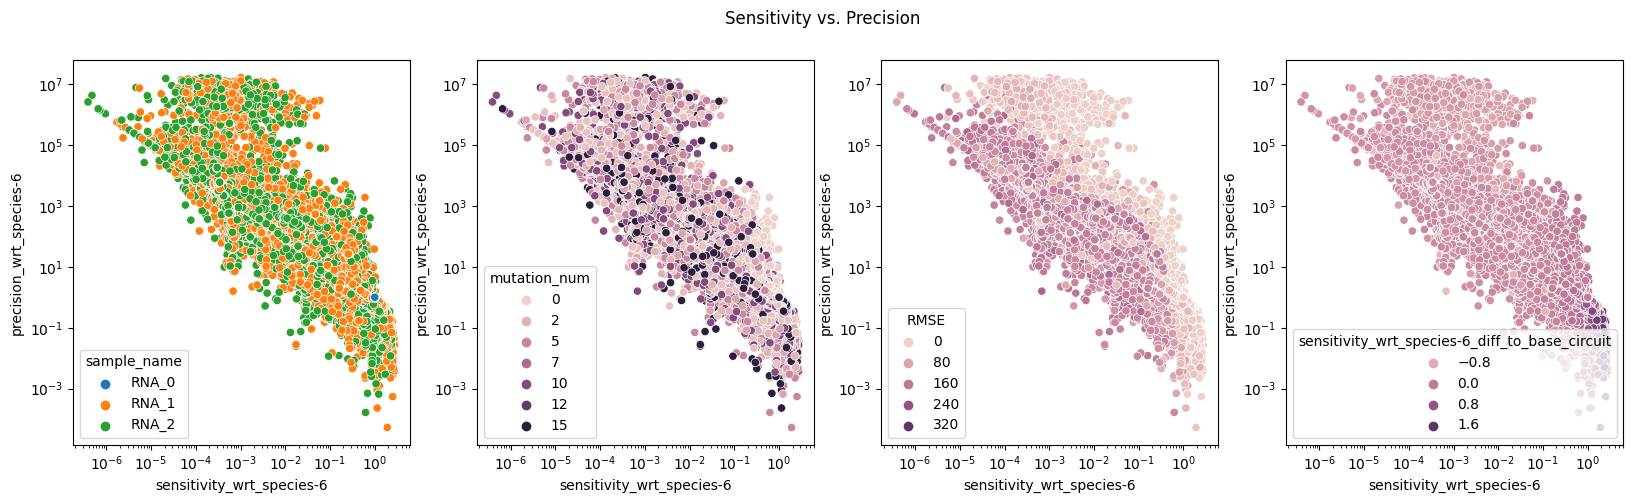

In [ ]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,4,1)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sample_name')
plt.xscale('log')
plt.yscale('log')
ax = plt.subplot(1,4,2)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='mutation_num')
plt.xscale('log')
plt.yscale('log')
ax = plt.subplot(1,4,3)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='RMSE')
plt.xscale('log')
plt.yscale('log')
ax = plt.subplot(1,4,4)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sensitivity_wrt_species-6_diff_to_base_circuit')
plt.xscale('log')
plt.yscale('log')

plt.suptitle('Sensitivity vs. Precision')

## Mutation effect

We can see that characterising the function of each circuit is doable through its analytics. We can therefore assess the effects of a mutation on the function of each circuit by seeing how the analytics change. The variation of an analytic within a circuit family would reveal how sensitive each starting circuit is to mutation. 

In [ ]:
# Mutation stats

good_cols = list(data.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(data, 'binding_rates_dissociation') + get_true_interaction_cols(data, 'eqconstants') +
get_true_interaction_cols(data, 'energies') + get_true_interaction_cols(data, 'binding_sites') + num_group_cols + num_bs_cols]
interaction = 'eqconstants'
datam = data[data['sample_name'] == 'RNA_0'].melt(good_cols, value_vars=get_true_interaction_cols(
    data, interaction), var_name='idx', value_name=interaction)

# binding rates by mutation num
# plt.figure(10, 10)
# for i in range(len(circuits[0].get_input_species())):
#     for j in range(i, len(circuits[0].get_input_species())):
#         ax = plt.subplot(len(circuits[0].get_input_species()), len(circuits[0].get_input_species()), i+j+1)
#         sns.histplot(data[data['sample_name'] == 'RNA_0'], x=f'binding_rates_dissociation_{i}-{j}', hue='mutation_num', log_scale=[False, True], element='step')
sns.histplot(datam, x=interaction, hue='mutation_num', log_scale=[False, True], element='step')

# variation within each circuit by mutation num

# variation within each circuit overall
# variation within each circuit overall by fraction of mutations in binding site

: 

: 